In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Barnes-Hut t-Distributed Stochastic Neighbour Embedding (t-SNE)

 Reference: [L. van der Maaten, "Accelerating t-SNE using Tree-Based Algorithms," J. Mach. Learn. Res., (2014)](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf).

 ## t-SNE

 t-SNE is an algorithm that maps data points in a high-dimensional space
 ($\mathcal{D} = \{\boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \}, \: \boldsymbol{x}_i \in \mathbb{R}^N$)
 to a 2-/3-dimensional embedding space ($\mathcal{E} = \{\boldsymbol{y}_1, \ldots, \boldsymbol{y}_n \}, \: \boldsymbol{y}_i \in \mathbb{R}^S$)
 while preserving as much as possible their local structure.

 The affinity in the original high-D space, $p_{j|i}$, is represented by Gaussian joint probabilities:

 $\begin{align} p_{j|i} &= \frac{ \mathcal{N}(d(\boldsymbol{x}_i, \boldsymbol{x}_j); 0, \sigma_i^2)}{\sum\limits_{k \neq i} \mathcal{N}(d(\boldsymbol{x}_i, \boldsymbol{x}_k); 0, \sigma_i^2)} \: (1 - \delta_{ij}) \\ p_{ij} &= \frac{p_{i|j} + p_{j|i}}{2 n} \\ \mathcal{N}(z; 0, \sigma^2) &= \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{z^2}{2 \sigma^2} \right) \end{align}$

 where $\sigma_i^2$ is width of the Gaussian kernel such that
 the *perplexity* at $\boldsymbol{x}_i$, $2^{H(P_i)}$,
 is equal to some given value $u$,
 where $H(P_i) = -\sum\limits_j p_{j|i} \log_2 p_{j|i}$ is the Shannon entropy.

 The affinity in the embedding space, $q_{j|i}$, is taken to follow the normalized Student-t distribution (with degree of freedom $n = 1$):

 $\begin{align} q_{ij} &= \frac{ \mathcal{T}(d(\boldsymbol{x}_i, \boldsymbol{x}_j); \nu = 1) }{\sum\limits_{k \neq l} \mathcal{T}(d(\boldsymbol{x}_k, \boldsymbol{x}_l); \nu = 1)} \: (1 - \delta_{ij}) \\ \mathcal{T}(z; \nu = 1) &= \frac{1}{\pi} \left(1 + z^2 \right)^{-1} \end{align}$

 The metric or distance function $d(\boldsymbol{x}_i, \boldsymbol{x}_j)$ could be the $L^2$ (Euclidean) norm $|| \boldsymbol{x}_i - \boldsymbol{x}_j ||_2$.

 The cost function $\mathcal{C}(\mathcal{E})$ is the Kullback-Leibler divergence between the two distributions:

 $\begin{align}  \mathcal{C}(\mathcal{E}) = D_\textrm{KL}(P \; || \; Q) = \sum\limits_{i, j \neq i} p_{ij} \: \log_2 \left( \frac{p_{ij}}{q_{ij}} \right) \end{align} $

 Although this function is non-convex, it can be minimized as usual by the gradient descent algorithm:

 $\begin{align} \frac{\partial \mathcal{C}}{\partial \boldsymbol{y}_i} &= 4 \sum\limits_{i, j \neq i} \left( p_{ij} - q_{ij} \right) q_{ij} \; A \left(\boldsymbol{y}_i - \boldsymbol{y}_j \right) \\ \boldsymbol{y}_i^{(m + 1)} &= \boldsymbol{y}_i^{(m)} - \eta \frac{\partial \mathcal{C}}{\partial \boldsymbol{y}_i} \end{align}$

 where $A = \sum\limits_{k \neq l} \mathcal{T}(d(\boldsymbol{x}_k, \boldsymbol{x}_l); \nu = 1)$ is a normalization term.

 The input affinities $p_{ij}$ can be approximated by noting its sparsity and restricting the denominator summation to $\mathcal{N}_i$,
 the set of $\lfloor 3 u \rfloor$ nearest neighbours to $\boldsymbol{x}_i$.

 $p_{ij} = \begin{cases} \frac{ \mathcal{N}(d(\boldsymbol{x}_i, \boldsymbol{x}_j); 0, \sigma_i^2)}{\sum\limits_{k \in \mathcal{N}_i} \mathcal{N}(d(\boldsymbol{x}_i, \boldsymbol{x}_k); 0, \sigma_i^2)} & \textrm{if } j \in \mathcal{N}_i \\ 0 & \textrm{otherwise} \end{cases}$

 $\mathcal{N}_i$ can be found by:

 1. building a *vantage-point tree* from $\mathcal{D}$ and $d(\boldsymbol{x}_i, \boldsymbol{x}_j)$;
 2. performing a nearest-neighbour search.



 ## Barnes-Hut Algorithm

 Note that the gradient of the cost function can be interpreted as the total force in a classical $n$-body problem:

 $\begin{align} \frac{\partial \mathcal{C}}{\partial \boldsymbol{y}_i} &= \left( 4 \sum\limits_{i, j \neq i} p_{ij} q_{ij} \; A \left(\boldsymbol{y}_i - \boldsymbol{y}_j \right) \right) + \left( - 4 \sum\limits_{i, j \neq i} q_{ij}^2 \; A \left(\boldsymbol{y}_i - \boldsymbol{y}_j \right) \right) \\ &= F_\textrm{att} + F_\textrm{rep} \end{align}$

 where $F_\textrm{att}, F_\textrm{rep}$ are spring-like attractive and repulsive forces.

 The term $q_{ij} \; A = \left(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j||^2 \right)^{-1}$ can be computed $\mathcal{O}(1)$.

 The term $F_\textrm{att}$ can be computed efficiently by considering summing over only the non-zero elements
 of the sparse distribution $P$ that was constructed using $\mathcal{N}_i$.

 Minimization of this quantity can be achieved using the Barnes-Hut algorithm:

 1. construct an *octree* from the embedding $\mathcal{E} = \{ \boldsymbol{y}_1, \ldots, \boldsymbol{y}_n \}$;
 2. traverse the octree using a depth-first search;
 3. at each node, decide if the corresponding cell could be taken altogether as the contribution of all its children to $F_\textrm{att}, F_\textrm{rep}$;
    - $\frac{r_\textrm{cell}}{|| \boldsymbol{y}_i - \boldsymbol{y}_\textrm{cell} ||} < \theta$ for some given $\theta \sim 0.5$;
    - if true, $F_\textrm{rep} \; A \approx - 4 N_\textrm{cell} \; q_{i, \textrm{cell}}^2 \; A^2 (\boldsymbol{y}_i - \boldsymbol{y}_\textrm{cell})$;
    - $r_\textrm{cell}$, side length of the cell; $N_\textrm{cell}$, the number of points $\boldsymbol{y}_i$ in the cell;
    - $\boldsymbol{y}_\textrm{cell}$, centre of mass of the cell; $q_{i, \textrm{cell}} \; A = \left(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_\textrm{cell}||^2 \right)^{-1}$
    - estimate $A = \sum\limits_{i \neq j} \left(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j||^2 \right)^{-1}$ in the same way;
    - thus $F_\textrm{rep} = \frac{F_\textrm{rep} \; A}{A}$.


 ---

 Input data for a $n$-body problem:
 - $\mathcal{D} = \{m_n, \boldsymbol{x}_n, \boldsymbol{v}_n, \boldsymbol{a}_n\}$;
 - $m_n$: mass/charge of the objects;
 - $\boldsymbol{x}_n, \boldsymbol{v}_n, \boldsymbol{a}_n$: position, velocity, and acceleration of the objects.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:

# Define input variables
num_dim_emb = 3
num_obj = 4
input_data = {
    'mass': np.ones((num_obj, 2)), 
    'pos': np.empty((num_obj, num_dim_emb)), 
    'vec': np.empty((num_obj, num_dim_emb)),
    'acc': np.zeros((num_obj, num_dim_emb)),
    }

# Generate test objects
np.random.seed(0)
def gen_rand_clusters(input_data, type):
    
    num_obj = input_data['mass'].shape[0]
    num_dim_emb = input_data['pos'].shape[1]

    if type == 'normal':
        input_data['pos'] = np.random.randn(num_obj, num_dim_emb)
        input_data['vec'] = np.random.randn(num_obj, num_dim_emb)
        input_data['acc'] = np.zeros((num_obj, num_dim_emb))

    return input_data


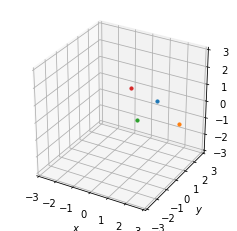

In [3]:
input_data = gen_rand_clusters(input_data, 'normal')

# Plot objects
fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(111, projection = '3d')
for obj_id in range(num_obj):
    _ = ax.scatter(input_data['pos'][obj_id, 0], input_data['pos'][obj_id, 1], input_data['pos'][obj_id, 2], s = 10*input_data['mass'][obj_id, 0])

i = np.ceil(np.max(np.abs([input_data['pos'].max(), input_data['pos'].min()])))
i = (-i, i)
_ = plt.setp(ax, xlim = i, ylim = i, zlim = i)
_ = plt.setp(ax, xlabel = '$x$', ylabel = '$y$', zlabel = '$z$')


 Let's $K$-th order symplectic integrators:

 $\begin{align} \textbf{for } k &\textbf{ in } [0, K) \textbf{ do } \\ & \boldsymbol{v}_i^{(k + 1)} := \boldsymbol{v}_i^{(k)} + d_k \; \boldsymbol{a}_i^{(k)} \Delta t  \\ & \boldsymbol{r}_i^{(k + 1)} := \boldsymbol{r}_i^{(k)} + c_k \; \boldsymbol{v}_i^{(k + 1)} \Delta t \\ & \boldsymbol{a}_i^{(k + 1)} := \frac{1}{m} \boldsymbol{F} \left( \boldsymbol{r}_i^{(k + 1)} \right) \end{align}$

 where the $k = 0$ and $k = 4$ terms are the inputs and outputs respectively.

In [4]:
def calc_int(obj_data, obj_id, t, delta_t, int_name, sum_name, force_name):

    num_dim_emb = obj_data['pos'].shape[1]
    m = obj_data['mass'][obj_id, 0]
    # q0 = obj_data['mass'][obj_id, 1]

    if t < 1:

        r_n = obj_data['pos'][obj_id, :, t]
        v_n = obj_data['vec'][obj_id, :, t]
        a_n = (1.0 / m) * calc_force_sum(r_n, obj_data, obj_id, t, sum_name, force_name)

        return r_n, v_n, a_n

    else:

        # Initialize from inputs
        r_n = obj_data['pos'][obj_id, :, t - 1]
        v_n = obj_data['vec'][obj_id, :, t - 1]
        a_n = (1.0 / m) * calc_force_sum(r_n, obj_data, obj_id, t - 1, sum_name, force_name)

        # Initialize outputs
        r_m = np.empty((1, num_dim_emb))
        v_m = np.empty((1, num_dim_emb))
        a_m = np.empty((1, num_dim_emb))

        # Symplectic integrator
        # e.g. 'symK' where K = 1, 2, 3, 4
        if int_name[0:3] == 'sym':

            # Order
            K = int(int_name[3])

            # Initialize
            r = np.empty((K + 1, num_dim_emb))
            v = np.empty((K + 1, num_dim_emb))
            a = np.empty((K + 1, num_dim_emb))
            r[0, :] = r_n
            v[0, :] = v_n
            a[0, :] = a_n

            if K > 0:

                # Symplectic coefficients
                c = np.empty(K)
                d = np.empty(K)

                if K == 0:
                    c[0] = 0.0
                    d[0] = 0.0

                elif K == 1:
                    c[0] = 1.0
                    d[0] = 1.0

                elif K == 2:
                    c[0] = 0.0
                    c[1] = 1.0
                    d[0] = 0.5
                    d[1] = 0.5

                elif K == 3:
                    c[0] = 1.0
                    c[1] = -2.0 / 3.0
                    c[2] = -c[1]
                    d[0] = -1.0 / 24.0
                    d[1] = 0.75
                    d[2] = 7.0 / 24.0

                elif K == 4:
                    i = 2**(1.0 / 3.0)
                    c[0] = 0.5 / (2.0 - i)
                    c[1] = 0.5 * (1.0 - i) / (2.0 - i)
                    c[2] = c[1]
                    c[3] = c[0]

                    d[0] = 1.0 / (2.0 - i)
                    d[1] = - i / (2.0 - i)
                    d[2] = d[0]
                    d[3] = 0.0
            
                # Iterate over k = 1 ... K
                for k in range(K):

                    v[k + 1, :] = v[k, :] + d[k] * a[k, :] * delta_t
                    r[k + 1, :] = r[k, :] + c[k] * v[k + 1, :] * delta_t
                    a[k + 1, :] = (1.0 / m) * calc_force_sum(r[k + 1, :], obj_data, obj_id, t - 1, sum_name, force_name)

            # Output
            r_m = r[K, :]
            v_m = v[K, :]
            a_m = a[K, :]

        return r_m, v_m, a_m



 Brute-force approach: sum over every object.

 Pairwise power-law force:
 $\begin{align} \boldsymbol{F}(\boldsymbol{r}_i) &= \pm \sum\limits_{j, j \neq i}^n \left( G m_i m_j \; ||\boldsymbol{r}_i - \boldsymbol{r}_j||^{n - 1} \right) \left( \boldsymbol{r}_i - \boldsymbol{r}_j \right)  \end{align}$

 Check the total momentum $\boldsymbol{P}$, kinetic energy $E_K$, and potential energy $E_P$:

 $\begin{align} \boldsymbol{P}(t) &= \sum\limits_i^n m_i \boldsymbol{v}_i(t) \\ E_K(t) &= \sum\limits_i^n \frac{1}{2} m_i || \boldsymbol{v}_i (t) ||^2 \\ E_P(t) &= \sum\limits_i^n  \sum\limits_{\tau = 1}^t -m_i \boldsymbol{a}_i(t) \cdot \left( \boldsymbol{r}_i (\tau) - \boldsymbol{r}_i(\tau - 1) \right) \end{align}$


In [5]:
 
def calc_force_sum(r_i, obj_data, obj_id, t, sum_name, force_name):

    num_obj = obj_data['mass'].shape[0]
    F = np.zeros((1, 3))
    # m_i = obj_data['mass'][obj_id, 0]
    q_i = obj_data['mass'][obj_id, 1]

    # Brute-force summation
    if sum_name == 'brute-force':

        for j in range(num_obj):

            if j != obj_id:

                # m_j = obj_data['mass'][j, 0]
                q_j = obj_data['mass'][j, 1]
                r_j = obj_data['pos'][j, :, t]
                
                F += calc_force(r_i, r_j, q_i, q_j, force_name)

    return F

def calc_force(r_1, r_2, q_1, q_2, force_name):

    # No force
    if force_name == 'none':

        F = np.zeros((1, 3))

    # Pairwise power-law force
    # 'pow_1.0' for attractive simple harmonic force
    # 'pow_2.0' for attractive inverse-square force
    elif force_name[0:3] == 'pow':

        if force_name[3] == '_':
            sgn = -1.0
            n = float(force_name[4:])
        else:
            sgn = 1.0
            n = float(force_name[3:])

        G = 1.0
        k = sgn * G * (q_1 * q_2) * (np.linalg.norm(r_1 - r_2, ord = 2))**(n - 1)
        F = k*(r_1 - r_2)

    return F


# Calculate total momentum, kinetic/potential energy of the system
def calc_kinetics(obj_data):

    # Total momentum
    P = np.matmul(np.transpose(output_data['vec']), output_data['mass'][:, 0])

    # Total kinetic energy
    # E_k = \sum_i 0.5 * m_i * v_i**2
    E_k = 0.5 * np.matmul(np.transpose(np.linalg.norm(output_data['vec'], ord = 2, axis = 1) ** 2), output_data['mass'][:, 0])

    # Total potential energy
    # E_p = - \sum_i F * dr
    num_t = obj_data['pos'].shape[2]
    num_obj = obj_data['mass'].shape[0]
    E_p = np.zeros(E_k.shape)
    for t in range(1, num_t):

        # Fast way
        E_p[t] = np.sum(np.asarray(list(map(lambda i: np.dot(obj_data['mass'][i, 0] * obj_data['acc'][i, :, t], obj_data['pos'][i, :, t] - obj_data['pos'][i, :, t - 1]), range(num_obj)))))

        # Slow way
        # for i in range(num_obj):
        #     F = obj_data['mass'][i, 0] * obj_data['acc'][i, :, t]
        #     delta_r = obj_data['pos'][i, :, t] - obj_data['pos'][i, :, t - 1]
        #     E_p[t] += -np.dot(F, delta_r)

    E_p = -np.cumsum(E_p)

    return P, E_k, E_p

# Calculate centre-of-mass motion
def calc_com(obj_data):

    num_obj = obj_data['mass'].shape[0]
    num_t = obj_data['pos'].shape[2]
    r_com = np.empty((num_dim_emb, num_t))
    v_com = np.empty((num_dim_emb, num_t))
    a_com = np.empty((num_dim_emb, num_t))

    # Total inertial mass
    # M = \sum_i m_i
    M = np.sum(obj_data['mass'][:, 0])

    # Centre-of-mass coordinates
    # r_com(t) = (1/M) \sum_i m_i r_i(t)
    for t in range(num_t):
        r_com[:, t] = np.sum(np.asarray(list(map(lambda i: obj_data['mass'][i, 0] * obj_data['pos'][i, :, t], range(num_obj)))), axis = 0)
        v_com[:, t] = np.sum(np.asarray(list(map(lambda i: obj_data['mass'][i, 0] * obj_data['vec'][i, :, t], range(num_obj)))), axis = 0)
        a_com[:, t] = np.sum(np.asarray(list(map(lambda i: obj_data['mass'][i, 0] * obj_data['acc'][i, :, t], range(num_obj)))), axis = 0)

    r_com = (1.0 / M) * r_com
    v_com = (1.0 / M) * v_com
    a_com = (1.0 / M) * a_com

    return r_com, v_com, a_com


In [6]:
T = 10.0
delta_t = 0.01
num_t = int(T / delta_t)
output_data = {
    'mass': input_data['mass'], 
    'pos': np.zeros((num_obj, num_dim_emb, num_t)), 
    'vec': np.zeros((num_obj, num_dim_emb, num_t)),
    'acc': np.zeros((num_obj, num_dim_emb, num_t)),
    }

output_data['pos'][:, :, 0] = input_data['pos']
output_data['vec'][:, :, 0] = input_data['vec']
output_data['acc'][:, :, 0] = input_data['acc']


In [7]:
for t in range(num_t):
    for obj_id in range(num_obj):

        r, v, a = calc_int(output_data, obj_id, t, delta_t, 'sym1', 'brute-force', 'pow_1.0')
        output_data['pos'][obj_id, :, t] = r
        output_data['vec'][obj_id, :, t] = v
        output_data['acc'][obj_id, :, t] = a

r_com, v_com, a_com = calc_com(output_data)
P, E_k, E_p = calc_kinetics(output_data)


[-13.846118441447736, 20.186501953471346, Text(0.5, 0, 'time')]

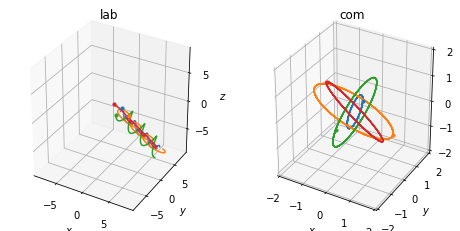

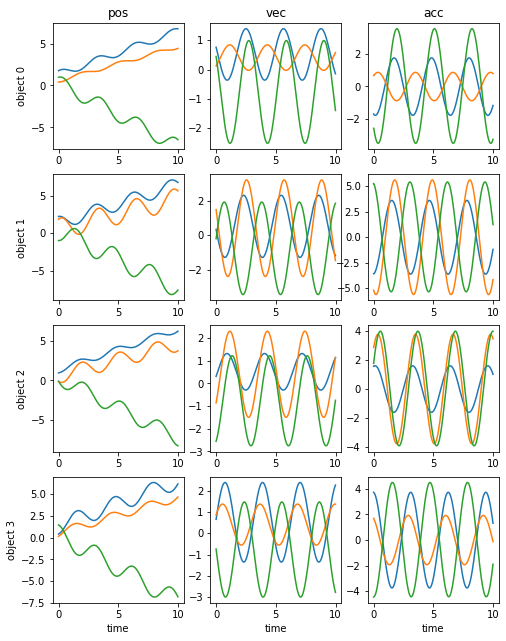

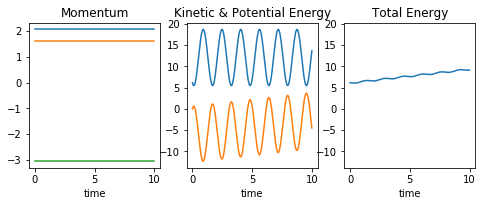

In [8]:
# Plot objects
fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot(121, projection = '3d')
for obj_id in range(num_obj):
    ax.plot(output_data['pos'][obj_id, 0, :], output_data['pos'][obj_id, 1, :], output_data['pos'][obj_id, 2, :])
for obj_id in range(num_obj):
    ax.scatter(output_data['pos'][obj_id, 0, 0], output_data['pos'][obj_id, 1, 0], output_data['pos'][obj_id, 2, 0], s = 10*output_data['mass'][obj_id, 0], marker = 'o')
ax.plot(r_com[0, :], r_com[1, :], r_com[2, :], linestyle = ':')
i = np.ceil(np.max(np.abs([output_data['pos'].max(), output_data['pos'].min()])))
i = (-i, i)
_ = plt.setp(ax, xlim = i, ylim = i, zlim = i)
_ = plt.setp(ax, title = 'lab', xlabel = '$x$', ylabel = '$y$', zlabel = '$z$')

ax = fig.add_subplot(122, projection = '3d')
for obj_id in range(num_obj):
    ax.plot(output_data['pos'][obj_id, 0, :] - r_com[0, :], output_data['pos'][obj_id, 1, :] - r_com[1, :], output_data['pos'][obj_id, 2, :] - r_com[2, :])

for obj_id in range(num_obj):
    ax.scatter(output_data['pos'][obj_id, 0, 0] - r_com[0, 0], output_data['pos'][obj_id, 1, 0] - r_com[1, 0], output_data['pos'][obj_id, 2, 0] - r_com[2, 0], s = 10*output_data['mass'][obj_id, 0], marker = 'o')

i = np.ceil(np.max(np.abs([(output_data['pos'] - r_com).max(), (output_data['pos'] - r_com).min()])))
i = (-i, i)
_ = plt.setp(ax, xlim = i, ylim = i, zlim = i)
_ = plt.setp(ax, title = 'com', xlabel = '$x$', ylabel = '$y$', zlabel = '$z$')


fig = plt.figure(figsize = (8, num_obj*(8/3)))
# ax = np.empty((num_obj, 3))
l = 1
for i in range(num_obj):
    for j in output_data.keys():
        if j != 'mass':

            ax = fig.add_subplot(num_obj, 3, l)

            for k in range(3):
                ax.plot(np.arange(0, T, delta_t), output_data[j][i, k, :])

            if i == 0:
                plt.setp(ax, title = j)

            if j == 'pos':
                plt.setp(ax, ylabel = f'object {i}')

            if i == (num_obj - 1):
                plt.setp(ax, xlabel = f'time')

            l += 1

fig = plt.figure(figsize = (8, 8/3))
ax = fig.add_subplot(131)
plt.setp(ax, title = 'Momentum', xlabel = 'time')
# ax.plot(np.arange(0, T, delta_t), np.linalg.norm(P, ord = 2, axis = 1))
for i in range(3):
    ax.plot(np.arange(0, T, delta_t), P[:, i])
ax = fig.add_subplot(132)
plt.setp(ax, title = 'Kinetic & Potential Energy', xlabel = 'time')
ax.plot(np.arange(0, T, delta_t), E_k)
ax.plot(np.arange(0, T, delta_t), E_p)
i = plt.getp(ax, 'ylim')
ax = fig.add_subplot(133)
plt.setp(ax, title = 'Total Energy')
ax.plot(np.arange(0, T, delta_t), E_k + E_p)
plt.setp(ax, ylim = i, xlabel = 'time')



 Define Barnes-Hut octree class:
 - steps
    1. define root node $x$;
    2. insert object $a$ in to $x$ if $x$ is empty;
    3. if $x$ is internal, update




 - Octant order (xyz)
    - counterclockwise in +z; clockwise in -z
    - +++, -++, --+, +-+, +--, ---, -+-, ++-

